In [22]:
import shap
import pickle
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
from tensorflow import keras 
import tensorflow as tf
import scipy.stats as st
from numpy import mean
from numpy import std
from tensorflow.keras.metrics import binary_accuracy
from sklearn.metrics import roc_auc_score, fbeta_score, recall_score, precision_score, accuracy_score
import seaborn as sns
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels as statsmodels
import statsmodels.stats.multitest as multitest
import copy

plt.style.use('seaborn-ticks')

In [23]:
#load train and test data

x_train = np.loadtxt('20210524_A1101_xtrain.txt')
x_test = np.loadtxt('20210524_A1101_xtest.txt')
y_train = np.loadtxt('20210524_A1101_ytrain.txt')
y_test = np.loadtxt('20210524_A1101_ytest.txt')
x_val = np.loadtxt('20210524_A1101_xval.txt')
y_val = np.loadtxt('20210524_A1101_yval.txt')

print(len(x_test))

629


In [24]:
#load model
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()
mload = tf.keras.models.load_model('20210608_A1101_final.model')

# #make predictions for whole dataset

allpredictions = mload.predict(np.asarray(x_test))

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [25]:
#Pick subset of data to use

# Full Dataset
x_testall = x_test
x_testsubset = x_test
x_trainall = x_train
datatrain = x_train


In [26]:
# Use training data as background, average it into 100 points
x_trainmeans = shap.kmeans(np.asarray(datatrain), 100)
explainer = shap.KernelExplainer(mload.predict, x_trainmeans)


In [27]:
#calculate shap values 
shap_values = explainer.shap_values(np.asarray(x_train))
#save shap_values as temp file
with open("shapvaluestemp.pkl","wb") as f:
    pickle.dump(shap_values,f)

In [28]:
# save shap_values, enter file name
with open("shapvaluesA1101_fromtrain.pkl","wb") as f:
    pickle.dump(shap_values,f)



In [29]:
###Extract from file
with open("shapvaluesA1101_fromtrain.pkl","rb") as f:
    shap_values = pickle.load(f)
    
shap_valuesall = shap_values


In [30]:
# transform the indexes to peptides with positions appended

char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

x_testpep = []
temppep = []
i = 0

while i < len(x_testsubset):
    j = 0
    while j < len(x_test[i]):
        temppep.append(str(char_index[int(x_testsubset[i][j])] + " " + str(j+1)))
        j+=1
    x_testpep.append(temppep)
    temppep = []
    i+=1


In [31]:
#split shap values and peptides into 8,9,10mers
print(x_testpep[0])
print(shap_values[0][0])

x_test8mers = []
x_test9mers = []
x_test10mers = []

x_testpep8mers = []
x_testpep9mers = []
x_testpep10mers = []

shap_values8mers = []
shap_values9mers = []
shap_values10mers = []

shap_values8mers.append([])
shap_values9mers.append([])
shap_values10mers.append([])

i = 0
while i < len(x_testpep):
    
    if 'END' in x_testpep[i][9]:
        if 'END' in x_testpep[i][8]:
                x_testpep8mers.append(x_testpep[i])
                shap_values8mers[0].append(shap_values[0][i])
                x_test8mers.append(x_test[i])
        else:
            x_testpep9mers.append(x_testpep[i])
            shap_values9mers[0].append(shap_values[0][i])
            x_test9mers.append(x_test[i])
    else:
        x_testpep10mers.append(x_testpep[i])
        shap_values10mers[0].append(shap_values[0][i])
        x_test10mers.append(x_test[i])
    i+=1
    
print(len(x_testpep))
print(len(x_testpep8mers)+len(x_testpep9mers)+len(x_testpep10mers))
print(shap_values8mers[0][0])

['C 1', 'H 2', 'K 3', 'G 4', 'W 5', 'G 6', 'V 7', 'S 8', 'V 9', 'END 10']
[-0.01882571  0.10546253  0.06474737 -0.04712352  0.04484458  0.00539715
  0.00218569 -0.03366855  0.2064883   0.07277782]
629
629
[-0.01952048  0.06548834  0.01680606  0.01975886 -0.01615372 -0.04288195
 -0.06700464 -0.02371613  0.03688051  0.02037641]


In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# create colormap by taking tab20 premade colormap and adding black to the bottom
upper = mpl.cm.tab20(np.arange(20))
lower = [0,0,0,1]
cmap1 = np.vstack(( lower, upper))

# convert to matplotlib colormap
cmap1 = mpl.colors.ListedColormap(cmap1, name='myColorMap', N=cmap1.shape[0])


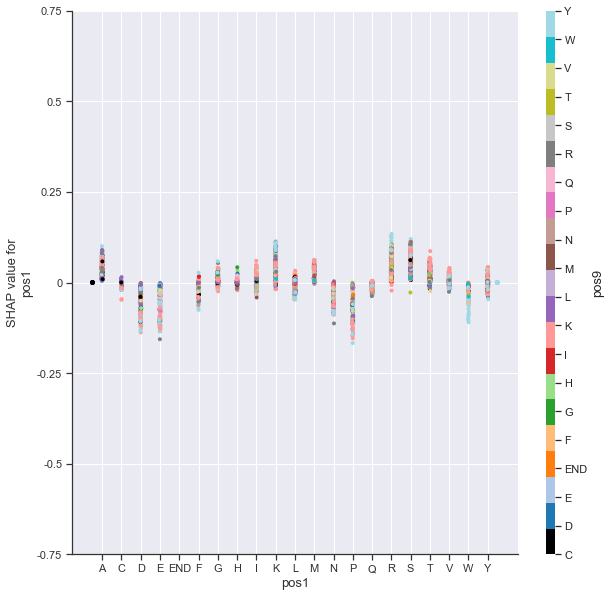

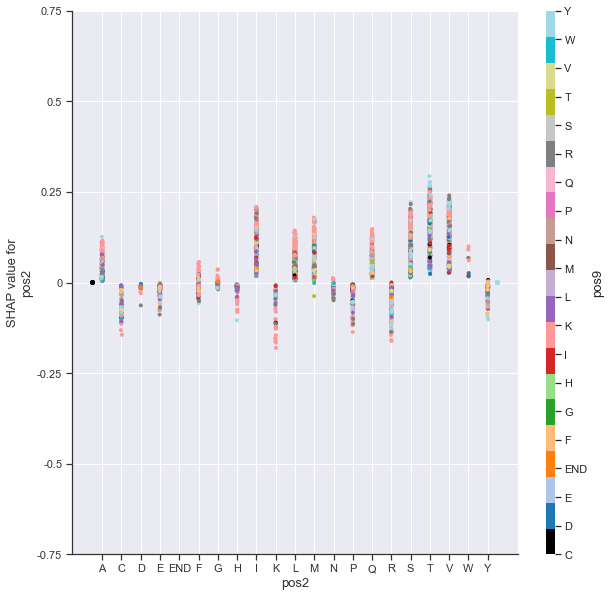

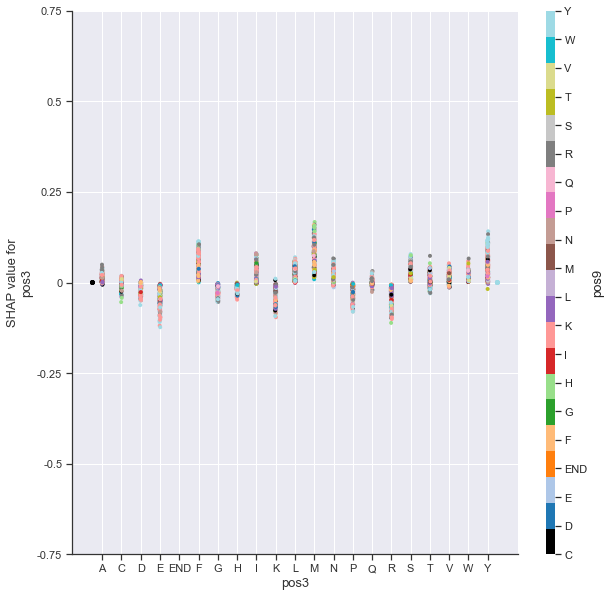

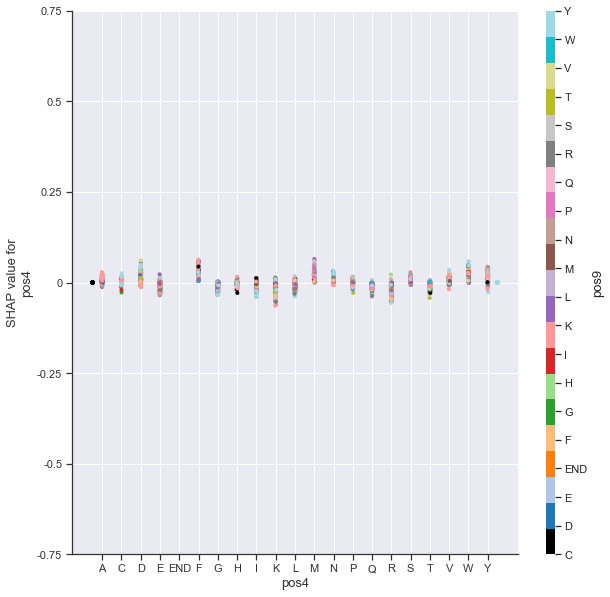

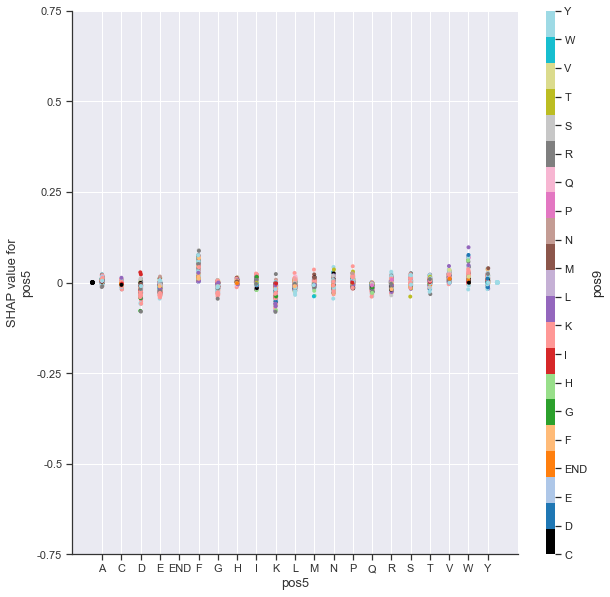

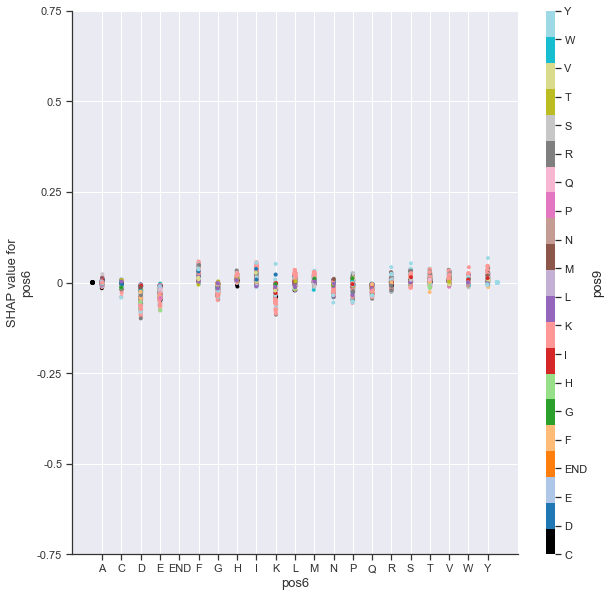

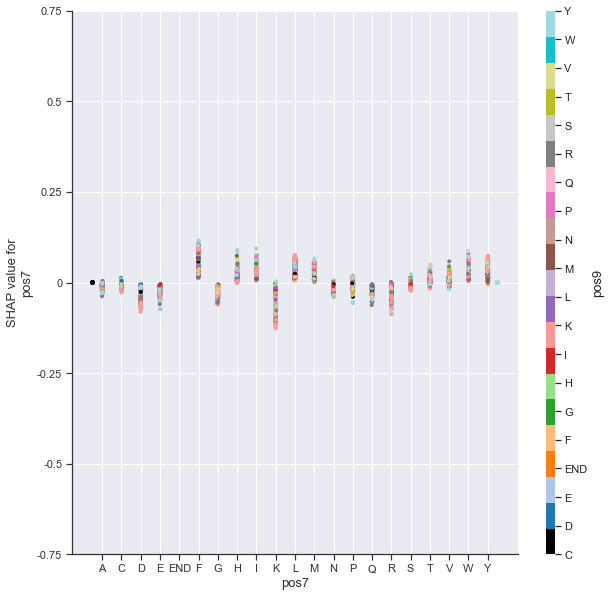

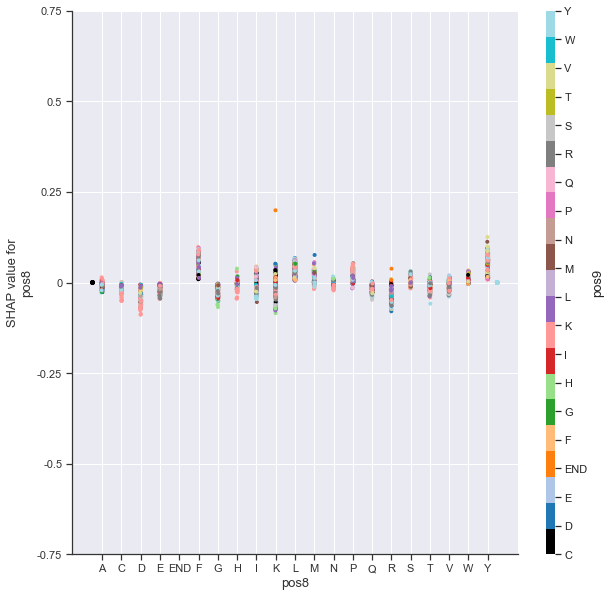

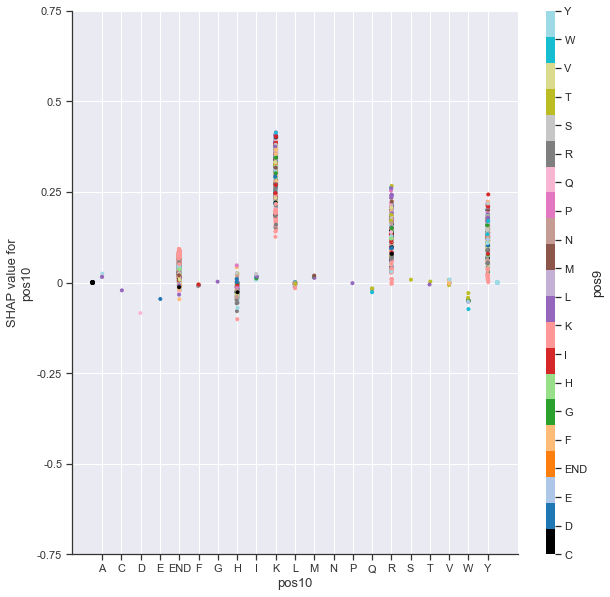

In [36]:
#Create Dependance plots for each of the positions shap.dependence_plot(a, shap_valuestmp[b], x_testadj, feature_names=['pos1', 'pos2', 'pos3','pos4', 'pos5', 'pos6','pos7', 'pos8', 'pos9','pos10'],  cmap=cmap1,show = False, x_jitter=.1,  interaction_index=c)
# a = position looking at
# b = allele looking at 
# c = position looking at interaction of i.e. colorbar
shap_values = shap_valuesall

#Modify shap_values and data arrays to fix dependence_plot rounding on colorbar
shap_valuestmp = []

i = 0
while i<len(shap_values):
    j=0
    tmppeps = []
    while j < len (shap_values[i]):
        k=0
        tmpposs = []
        while k < len (shap_values[i][j]):
            tmpposs.append(shap_values[i][j][k])
            k+=1
        tmppeps.append(tmpposs)
        j+=1
    f=0
    #add 2000 blank shap values to make color bar right
    while f<200:
        tmppeps.append([0,0,0,0,0,0,0,0,0,0])
        f+=1

    shap_valuestmp.append(tmppeps)
    
    i+=1
    
shap_valuestmp = np.array(shap_valuestmp)
i = 0
x_testadj = []
x_test = x_train
while i < len(x_test):
    tmp = []
    for value in x_test[i]:
        tmp.append(value)
    x_testadj.append(tmp)
    i+=1
i = 0
while i<100:    
    x_testadj.append([-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5])
    i+=1
i = 0
while i<100:
    x_testadj.append([20.5,20.5,20.5,20.5,20.5,20.5,20.5,20.5,20.5,20.5])
    
    i+=1
x_testadj = np.array(x_testadj)

y = [-0.75,-0.5,-0.25,0,0.25,0.5,0.75]
yt = [-0.75,-0.5,-0.25,0,0.25,0.5,0.75]
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
xt = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']


pos = 0

#set to allele index
allele = 0

#set to 'static', 'preceding', 'following'
compareto = 'static'
compared = 8


while pos < 10:
    
    if compareto == 'preceding':
        if pos == 0 or pos == 1:
            compared = 9
        else:
            compared = pos-2
            
    if compareto == 'following':
        if pos == 9:
            compared = 0
        else:
            compared = pos+1
    if pos != compared:
        
        
    
        shap.dependence_plot(pos, shap_valuestmp[allele], x_testadj, feature_names=['pos1', 'pos2', 'pos3','pos4', 'pos5', 'pos6','pos7', 'pos8', 'pos9','pos10'],  cmap=cmap1, show = False, x_jitter=.1,  interaction_index=compared)
        plt.yticks(y,yt)
        plt.xticks(x,xt)

        fig = plt.gcf()
        fig.set_size_inches(10,10)
        #plt.set_clim(0,1)
        #plt.figure(figsize=(20, 10))
        cbs = []

        for ax in fig.axes:
            cbs.extend(ax.findobj(lambda obj: hasattr(obj, "colorbar") and obj.colorbar))

        colorb = cbs[0].colorbar
        #colorb.set_clim(-1, 21)
        z = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
        zt = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

        colorb.set_ticks(z)
        colorb.set_ticklabels(zt)
        #ax = plt.gca()
        #imshowobj = plt.imshow(x_testadj)
        #cbarobj = plt.colorbar(imshowobj, cmap=cmap1, ax= fig.axes[-1])
        #imshowobj.set_clim(0,20)

        plt.savefig('dependenceplotnew' + str(pos) + '.svg', bbox_inches="tight", format = 'svg', dpi=1000)
        plt.show()
    
    pos+=1





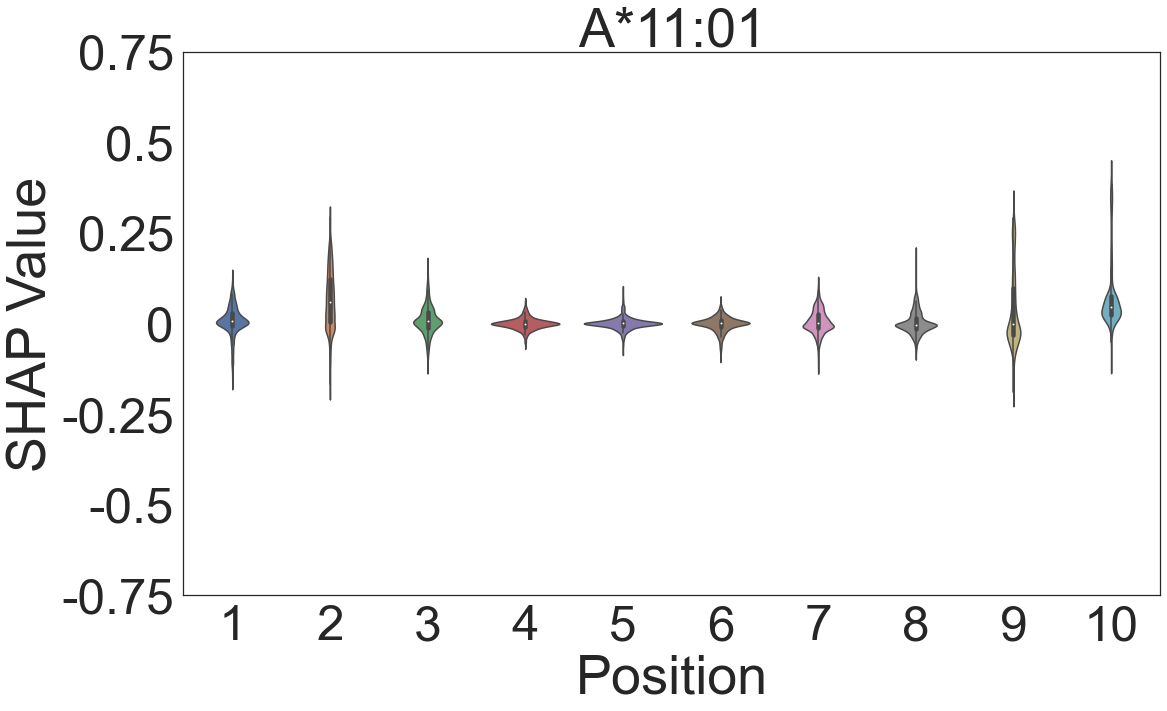

In [37]:
#shap values by position
positionalshaps = [[],[],[],[],[],[],[],[],[],[]]
i = 0

while i < len(shap_values[0]):
    j = 0
    while j < len(shap_values[0][i]):
        positionalshaps[j].append(shap_values[0][i][j])
        j+=1
    i+=1

sns.set_style("white")  
sns.violinplot(data=positionalshaps)
fig = plt.gcf()
fig.set_size_inches(17.5,10)


sns.set(font_scale = 4.5)
plt.title("A*11:01")
plt.xlabel("Position")
plt.ylabel("SHAP Value")
plt.yticks(y,yt)
plt.xticks([0,1,2,3,4,5,6,7,8,9],["1" ,"2" ,"3","4","5","6","7","8","9","10"])



plt.savefig("positionSHAPrangeA1101_TRAIN.svg")
plt.show()

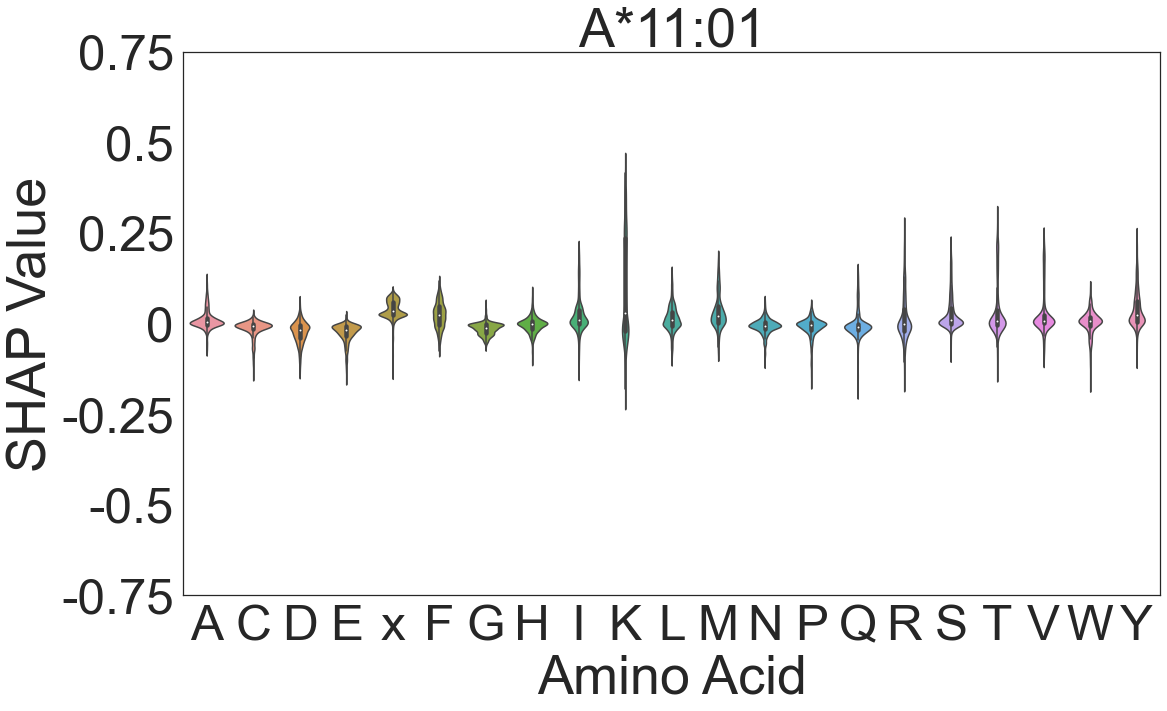

In [38]:
#shap values by amino acid
char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
aminoacidshaps = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
i=0
while i < len(shap_values[0]):
    j = 0
    while j < len(shap_values[0][i]):
        aminoacidshaps[int(x_test[i][j])].append(shap_values[0][i][j])
        j+=1
    i+=1

sns.set_style("white") 
sns.violinplot(data=aminoacidshaps)
xt = ['A','C','D','E','x','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
plt.yticks(y,yt)
plt.xticks(x,xt)
plt.title("A*11:01")
plt.xlabel("Amino Acid")
plt.ylabel("SHAP Value")
sns.set_style("white") 
sns.set(font_scale = 4.5)
fig = plt.gcf()
fig.set_size_inches(17.5,10)
plt.savefig("aminoacidSHAPrangeA1101_TRAIN.svg")
plt.show()

In [39]:
#dependence analysis
import copy
shap_values = shap_valuesall
x_test = x_train
aa = []

i = 0
j = 0
while i < 10:
    aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i = 0
j = 0


char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']


i=0
j=0
k=0


#through the positions
while (i < len(shap_values[0][0])):
    j=0
    shappostmp = []
    #through the values
    while (j < 21):
        #through the list
        k = 0
        while (k < len(shap_values[0])):
            #place each shap value corresponding to an amino acid into a new array
            if j == x_test[k][i]:
                aa[i][j].append(shap_values[0][k][i])
                
            k+=1
        j+=1
    i+=1
    
i = 0
j = 0


aadep = []

i = 0
j = 0
while i < 10:
    aadep.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i = 0
j = 0
temp = []
while i < len(shap_values[0][0]):
    temp.append(copy.deepcopy(aadep))
    i+=1
i = 0
deparray = []

while i < 21:
    deparray.append(copy.deepcopy(temp))
    i+=1
    
    
    
compaadep = []

i = 0
j = 0
while i < 10:
    compaadep.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i = 0
j = 0
comptemp = []
while i < len(shap_values[0][0]):
    comptemp.append(copy.deepcopy(compaadep))
    i+=1
i = 0
compdeparray = []

while i < 21:
    compdeparray.append(copy.deepcopy(comptemp))
    i+=1
    


char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']


i=0
j=0
k=0
a = 0
b = 0
#through the amino acids
while (a<21):
    b=0
    while (b < len(shap_values[0][0])):
        #through the positions
        i=0
        while (i < len(shap_values[0][0])):
            j=0
            
            #through the values
            if (b != i):
                #print("b!=i")
                #print(b)
                while (j < 21):
                    #through the list
                    k = 0
                    while (k < len(shap_values[0])):
                        #place each shap value corresponding to an amino acid into a new array
                        if j == x_test[k][i] and x_test[k][b] == a:
                            deparray[a][b][i][j].append(shap_values[0][k][i])
                        if j == x_test[k][i] and x_test[k][b] != a:
                            compdeparray[a][b][i][j].append(shap_values[0][k][i])
                        
                        k+=1
                    j+=1
            i+=1
        b+=1
    a+=1

    i = 0
j = 0
    
        

print(deparray[0][0][0])
print(compdeparray[0][0][0])
    
a = 0
b = 0
c = 0
d = 0

#Remove extra zeros
i=0
j=0
k=0
a = 0
b = 0
while (a<len(deparray)):
    b=0
    while (b < len (deparray[a])):
        i=0
        while(i < len(deparray[a][b])):
            j=0
            while(j < len(deparray[a][b][i])):
                
                if len(deparray[a][b][i][j])>1:
                    
                    deparray[a][b][i][j] = deparray[a][b][i][j][1:]
                
                if len(compdeparray[a][b][i][j])>1:
                    
                    compdeparray[a][b][i][j] = compdeparray[a][b][i][j][1:]
                
                    
                j+=1
            i+=1
        b+=1
    a+=1


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


In [40]:
outputarray = []
char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
a = 0
b = 0
c = 0
d = 0
e = 0

while a < len(deparray):
    b = 0
    while b < len(deparray[a]):
        c = 0
        while c<len(deparray[a][b]):
            d = 0
            while d < len(deparray[a][b][c]):
                
                stat,test = st.mannwhitneyu(deparray[a][b][c][d][1:], compdeparray[a][b][c][d][1:])
                if test<1 and test>0:
                    
                    outputarray.append([test,char_index[a],b+1,c+1,char_index[d],len(deparray[a][b][c][d][1:]),len(compdeparray[a][b][c][d][1:]),np.mean(deparray[a][b][c][d][1:]),np.mean(compdeparray[a][b][c][d][1:]), abs(np.mean(compdeparray[a][b][c][d][1:])-np.mean(deparray[a][b][c][d][1:])), np.mean(deparray[a][b][c][d][1:])-np.mean(compdeparray[a][b][c][d][1:])])
                    e+=1
                d+=1
            c+=1
        b+=1
    a+=1

outputdf = pd.DataFrame(outputarray, columns = ["mw pvalue", "compared amino acid", "compared position", "position", "amino acid","compared size","total size", "compared mean", "total mean", "abs difference", "difference"]) 
corrmwtest = multitest.multipletests(outputdf['mw pvalue'].tolist(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
outputdf.insert(1, "corr mw pvalue", corrmwtest[1])

outputdf = outputdf.sort_values(by='corr mw pvalue', ascending=True)

divide by zero encountered in double_scalars


In [41]:
outputdf.to_csv("a1101depanalysistrain.csv")

4522


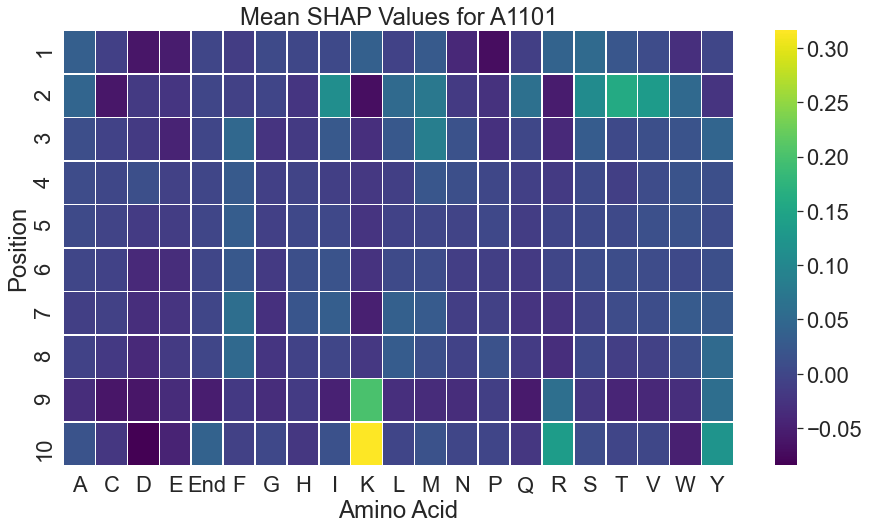

In [47]:
#Create Mean Heatmap

import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
x_testsubset = x_train
x_testpep = x_testpep
shap_valuestmp = shap_valuesall
shap_values = shap_valuesall



# Full Dataset
with open("shapvaluesA1101_fromtrain.pkl","rb") as f:
    shap_values = pickle.load(f)

    x_testsubset = x_train
    print(len(x_test))
    shap_valuestmp = shap_values






    
x = 0
    
    
char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

x_testpep = []
temppep = []
i = 0

while i < len(x_testsubset):
       
    j = 0
    while j < len(x_test[i]):
        #print(x_testsubset[i][j])
        #temppep.append(str(char_index[int(x_testsubset[i][j])] + " " + str(j+1)))
        temppep.append(str(char_index[int(x_testsubset[i][j])] + " " + str(j+1)))
        j+=1
    x_testpep.append(temppep)
    temppep = []
    i+=1
x_testsubset = x_train
x_testpep = x_testpep
shap_valuestmp = shap_values
shap_values = shap_values    

while x < 1:
    aa = []
    i = 0
   
    while i < 10:
        aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
        i+=1

    char_index = ['A','C','D','E','END','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    #create 3D array to keep track of amino acid position shap values
    
    i = 0
    
    while i < len(x_testsubset):
        j=0

        while j < len(x_testsubset[i]):
            
            while True:
                try:
                    
                    
                    aa[j][int(x_testsubset[i][j])].append(shap_valuestmp[x][i][j])
                    break
                except IndexError:
                    print('j=' + str(j))
                    print('i=' + str(i))
                    print('x=' + str(x))
                    print('len of aa =' + str(len(aa)))
                    print('len of aa[j] =' + str(len(aa[0])))
                    print('len of x_testsubset' + str(len(x_testsubset)))
                    print('len of x_testsubset[i]' + str(len(x_testsubset[i])))
                    print('len of shap' + str(len(shap_valuestmp)))
                    print('len of shap[x]' + str(len(shap_valuestmp[x])))
                    print('shap[x]' + str(shap_valuestmp[x]))
                    print('len of shap[x][i]' + str(len(shap_valuestmp[x][i])))
              
            
            j+=1
        i+=1  
    heatmap = []
    i = 0
    while i < len(aa):
        j=0
        heatmap.append([])
        while j < len(aa[i]):
            if len(aa[i][j]) > 1:

               
                #mean
                heatmap[i].append((sum(aa[i][j])/float(len(aa[i][j])-1)))
                
                
            else:
                heatmap[i].append(0)

            j+=1
        i+=1
    heatmap = np.array(heatmap)
    
    
    
   
    
    
    plt.figure()
    x_axis_labels = ['A','C','D','E','End','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
    y_axis_labels = ['1','2','3','4','5','6','7','8','9','10']
    sns.set(font_scale=2)

    # figure size in inches
    rcParams['figure.figsize'] = 15,8

    ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,linewidths=.5,  cmap="viridis")


    ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean SHAP Values for A1101')
    ax.figure.savefig('A1101allmers.png')
    ax.figure.savefig('A1101allmers.svg')
    plt.show()
    x+=1